# Group Classification (ZenML)

Train the `GroupClassifier` on real preprocessed time-group data:
- Load preprocessed time groups from .npy files in the data folder
- Train the `GroupClassifier` via a ZenML pipeline with Optuna hyperparameter tuning
- Reload artifacts and render evaluation plots (confusion matrices, ROC curves, etc.)


In [1]:
from pathlib import Path
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines.training import group_classification_optuna_pipeline
from pioneerml.data import CLASS_NAMES, NUM_GROUP_CLASSES

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")


Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default


In [2]:
# Configure the pipeline
# Use absolute path based on project root
file_pattern = str(Path(PROJECT_ROOT) / 'data' / 'mainTimeGroups_*.npy')
run = group_classification_optuna_pipeline.with_options(enable_cache=False)(
    build_datamodule_params={
        # Data loading parameters
        'file_pattern': file_pattern,
        'max_files': 1,              # Limit number of files to load
        'limit_groups': 1000000,       # Cap total groups for quicker iterations
        'min_hits': 2,
        'min_hits_per_label': 2,
        # Datamodule parameters
        'batch_size': 128,
        'num_workers': None,         # None = auto-detect (uses #CPU cores - 1)
                                     # Set to 0 to disable multiprocessing
                                     # Set to a specific number to override
        'val_split': 0.15,
        'seed': 42,
    },
    run_hparam_search_params={
        'n_trials': 1,               # Optuna trials for the search step
        'max_epochs': 3,             # epochs per trial during search
        'limit_train_batches': 0.8,   # fraction/int of train batches per trial
        'limit_val_batches': 1.0,     # fraction/int of val batches per trial
    },
    train_best_model_params={
        'max_epochs': 15,             # final training epochs cap
        'early_stopping': True,        # enable early stopping
        'early_stopping_patience': 4, # patience for early stopping
        'early_stopping_monitor': 'val_loss',
        'early_stopping_mode': 'min',
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: group_classification_optuna_pipeline.
Caching is disabled by default for group_classification_optuna_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  deployer: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_group_classification_datamodule has started.


[build_group_classification_datamodule] Auto-detected num_workers: 11 (from 12 CPU cores, using cores-1)
[build_group_classification_datamodule] Starting to load data from: /home/jack/python_projects/pioneerML/data/mainTimeGroups_*.npy
[build_group_classification_datamodule] Limiting to 1 files (from 11 total files found, max_files=1)
[build_group_classification_datamodule] Loaded 29370 groups from 1 files (pion: 10000, muon: 9998, mip: 9998)
[build_group_classification_datamodule] Loaded 29370 groups. Building datamodule...
[build_group_classification_datamodule] Calling setup(stage='fit')...
[build_group_classification_datamodule] Setup complete. Train: 24965, Val: 4405


Step build_group_classification_datamodule has finished in 2.800s.
Step run_group_classification_hparam_search has started.


[run_group_classification_hparam_search] Using GPU: NVIDIA GeForce RTX 5070
[run_group_classification_hparam_search] CUDA devices: 1
[run_group_classification_hparam_search] Enabled Tensor Core optimization (medium precision)
[run_group_classification_hparam_search] Dataset sizes - Train: 24965, Val: 4405
[run_group_classification_hparam_search] Starting Optuna search with 1 trials, 3 epochs per trial...
[I 2025-12-03 01:19:46,694] A new study created in memory with name: no-name-fe283efe-0ed3-406c-a224-72033405dff9
[run_group_classification_hparam_search] Starting Optuna study...


  0%|          | 0/1 [00:00<?, ?it/s]

[run_group_classification_hparam_search] Trial 1/1 starting...
[run_group_classification_hparam_search] Trial 1 params: batch_size=128, hidden=256, num_blocks=4, dropout=0.2107, lr=0.002408, weight_decay=0.000655
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 1 training 3 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  4.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.2 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=3` reached.


[run_group_classification_hparam_search] Trial 1 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 1 completed with score: 0.988498
[run_group_classification_hparam_search] Optuna search complete! Best score: 0.988498
[run_group_classification_hparam_search] Best params: {'batch_size': 128, 'hidden': 256, 'num_blocks': 4, 'dropout': 0.21067719814450897, 'lr': 0.0024084524142544907, 'weight_decay': 0.0006554525905037216}


[I 2025-12-03 01:20:27,289] Trial 0 finished with value: 0.9884980916976929 and parameters: {'batch_size': 128, 'hidden': 256, 'num_blocks': 4, 'dropout': 0.21067719814450897, 'lr': 0.0024084524142544907, 'weight_decay': 0.0006554525905037216}. Best is trial 0 with value: 0.9884980916976929.
Step run_group_classification_hparam_search has finished in 53.793s.
Step train_best_group_classifier has started.


[train_best_group_classifier] Starting final model training...
[train_best_group_classifier] Dataset sizes - Train: 24965, Val: 4405
[train_best_group_classifier] Using GPU: NVIDIA GeForce RTX 5070
[train_best_group_classifier] CUDA devices: 1
[train_best_group_classifier] Enabled Tensor Core optimization (medium precision)
[train_best_group_classifier] Training configuration:
[train_best_group_classifier]   max_epochs: 15
[train_best_group_classifier]   early_stopping: True
[train_best_group_classifier]   early_stopping_patience: 6
[train_best_group_classifier] Starting training...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  4.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.2 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_loss improved. New best score: 0.055
Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.025
Monitored metric val_loss did not improve in the last 6 records. Best score: 0.025. Signaling Trainer to stop.


[train_best_group_classifier] Training complete! Final epoch: 9


Step train_best_group_classifier has finished in 2m17s.
Step collect_group_classification_predictions has started.
Step collect_group_classification_predictions has finished in 58.874s.
Pipeline run has finished in 4m15s.
Run name: group_classification_optuna_pipeline-2025_12_03-06_19_29_909700
Run status: completed


In [3]:
trained_module = load_step_output(run, "train_best_group_classifier")
datamodule = load_step_output(run, "build_group_classification_datamodule")
predictions = load_step_output(run, "collect_group_classification_predictions", index=0)
targets = load_step_output(run, "collect_group_classification_predictions", index=1)
best_params = load_step_output(run, "run_group_classification_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")
print("Best params from Optuna:", best_params)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))


Loaded module on cpu; validation samples: 4405
Best params from Optuna: {'batch_size': 128, 'hidden': 256, 'num_blocks': 4, 'dropout': 0.21067719814450897, 'lr': 0.0024084524142544907, 'weight_decay': 0.0006554525905037216, 'best_score': 0.9884980916976929, 'n_trials': 1} {'batch_size': 128, 'hidden': 256, 'num_blocks': 4, 'dropout': 0.21067719814450897, 'lr': 0.0024084524142544907, 'weight_decay': 0.0006554525905037216, 'best_score': 0.9884980916976929, 'n_trials': 1}
Epochs actually run: 9 9


In [4]:
# Class names for group classification
class_names = [CLASS_NAMES[i] for i in range(NUM_GROUP_CLASSES)]
print("Class names (index-aligned):", class_names)


Class names (index-aligned): ['pion', 'muon', 'mip'] ['pion', 'muon', 'mip']


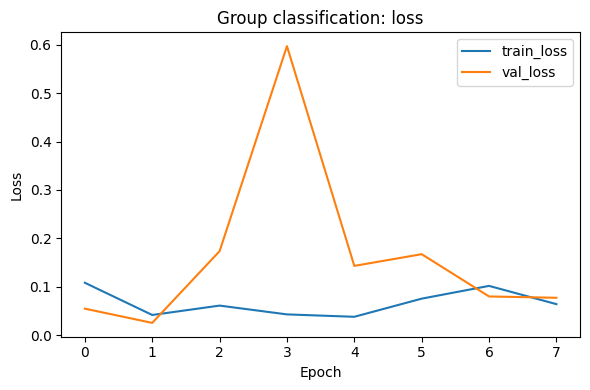

/home/jack/python_projects/pioneerML/src/pioneerml/evaluation/plots.py:51: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-scores))



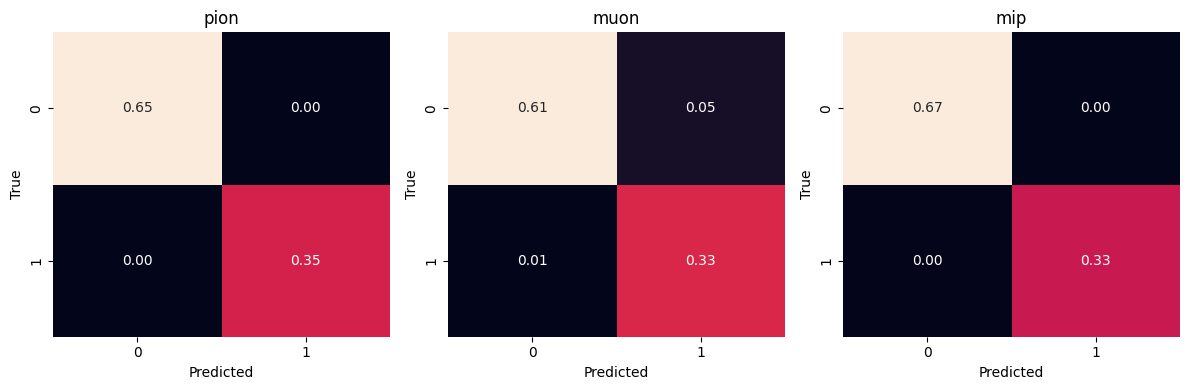

/home/jack/python_projects/pioneerML/src/pioneerml/evaluation/plots.py:51: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-scores))



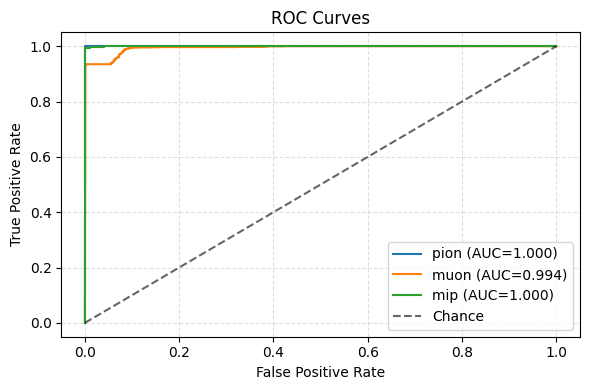

/home/jack/python_projects/pioneerML/src/pioneerml/evaluation/plots.py:51: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-scores))



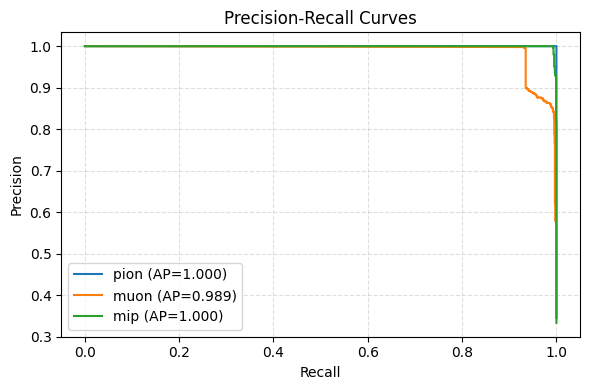

In [5]:
from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)

plot_loss_curves(trained_module, title="Group classification: loss", show=True)
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    threshold=0.5,
    normalize=True,
    show=True,
)
plot_roc_curves(predictions, targets, class_names=class_names, show=True)
plot_precision_recall_curves(predictions, targets, class_names=class_names, show=True)


## Save the Trained Model

Save the trained model and metadata for later use.


In [6]:
import torch
import json
from datetime import datetime

# Create checkpoints directory
checkpoints_dir = Path(PROJECT_ROOT) / "artifacts" / "checkpoints" / "group_classifier"
checkpoints_dir.mkdir(parents=True, exist_ok=True)

# Generate a timestamped filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"group_classifier_{timestamp}.pt"
metadata_filename = f"group_classifier_{timestamp}_metadata.json"

# Extract the underlying model from the Lightning module
model = trained_module.model
model.eval()

# Save model state_dict
model_path = checkpoints_dir / model_filename
torch.save(model.state_dict(), model_path)
print(f"Saved model state_dict to: {model_path}")

# Save metadata (hyperparameters, training info, etc.)
metadata = {
    "model_type": "GroupClassifier",
    "timestamp": timestamp,
    "run_name": run.name,
    "best_hyperparameters": best_params,
    "training_config": getattr(trained_module, "training_config", {}),
    "epochs_run": getattr(trained_module, "final_epochs_run", None),
    "dataset_info": {
        "train_size": len(datamodule.train_dataset) if datamodule.train_dataset else 0,
        "val_size": len(datamodule.val_dataset) if datamodule.val_dataset else 0,
        "num_classes": NUM_GROUP_CLASSES,
        "class_names": class_names,
    },
    "model_architecture": {
        "num_classes": NUM_GROUP_CLASSES,
        "hidden": best_params.get("hidden"),
        "num_blocks": best_params.get("num_blocks"),
        "dropout": best_params.get("dropout"),
    },
}

metadata_path = checkpoints_dir / metadata_filename
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata to: {metadata_path}")

print(f"\nModel saved successfully!")
print(f"  Model: {model_path}")
print(f"  Metadata: {metadata_path}")


Saved model state_dict to: /home/jack/python_projects/pioneerML/artifacts/checkpoints/group_classifier/group_classifier_20251203_012349.pt
Saved metadata to: /home/jack/python_projects/pioneerML/artifacts/checkpoints/group_classifier/group_classifier_20251203_012349_metadata.json

Model saved successfully!
  Model: /home/jack/python_projects/pioneerML/artifacts/checkpoints/group_classifier/group_classifier_20251203_012349.pt
  Metadata: /home/jack/python_projects/pioneerML/artifacts/checkpoints/group_classifier/group_classifier_20251203_012349_metadata.json
